In [7]:
import numpy as np
import matplotlib.pyplot as plt


def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']

    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z

    return np.array([dx, dy, dz])

time_steps = np.arange(0, 1500, 0.1)
params = {'σ' : 10., 'ρ' : 28., 'β' : 8/3}
xyz0 = np.array([1., 1., 1.])
lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
x, y, z = lorenz_solution[2000:].T
x = (x - min(x)) / (max(x) - min(x))
import itertools
import tqdm
from sklearn.cluster import DBSCAN
from collections import Counter
Zs = []
patterns = []

In [12]:
def generate_patterns(K, L):
    patterns = np.array(list(itertools.product(np.arange(1, K+1), repeat=L)))
    return patterns

def sample_z_vectors(x, pattern):
    T = len(x)
    ind = np.array([0, *np.cumsum(pattern)])

    samples = []
    for i in range(T-ind[-1]):
        samples.append(x[ind+i])
    return np.array(samples)

def sample_z_new(x, pattern):
    ind = np.array([0, *np.cumsum(pattern)])
    T = len(x) - ind[-1]
    return x[ind[:-1] + T]

def dbscan(S, x_i):
    if len(S) > 0:
        dbscan = DBSCAN(eps = 0.01, min_samples = 100)
        labels = dbscan.fit_predict(S)
        unique_labels, counts = np.unique(labels, return_counts=True)
        if len(unique_labels) > 1:
            largest_cluster_index = np.argmax(counts[1:]) + 1
            largest_cluster_label = unique_labels[largest_cluster_index]
            largest_cluster_points = S[labels == largest_cluster_label][:, 0]
            mean_largest_cluster = np.mean(largest_cluster_points)
            if abs(mean_largest_cluster - x_i) / x_i <= 0.025:
                return mean_largest_cluster
            else:
                return 0
        else:
            return 0
    else:
        return 0

def self_healing(x_new):
    counter = 0
    for i in range(len(x_new)):
        if (x_new[i] == 0):
            S = []
            for j, pattern in tqdm.tqdm(enumerate(patterns)):
                ind = np.array([0, *np.cumsum(pattern)])
                if (i + ind[4] < len(x_new)):
                    z_new = x_new[ind[[1, 2, 3, 4]] + i]
                    if (z_new[0] != 0 and z_new[1] != 0 and z_new[2] != 0 and z_new[3] != 0):
                        S.extend(Zs[j][np.linalg.norm(Zs[j][:, [1, 2, 3, 4]] - z_new, axis=1) < 0.01][:, 0])
                if (i + ind[4] - ind[1] < len(x_new) and i - ind[1] > -1):
                    z_new = x_new[ind[[0, 2, 3, 4]] + i - ind[1]]
                    if (z_new[0] != 0 and z_new[1] != 0 and z_new[2] != 0 and z_new[3] != 0):
                        S.extend(Zs[j][np.linalg.norm(Zs[j][:, [0, 2, 3, 4]] - z_new, axis=1) < 0.01][:, 1])
                if (i + ind[4] - ind[2] < len(x_new)  and i - ind[2] > -1):
                    z_new = x_new[ind[[0, 1, 3, 4]] + i - ind[2]]
                    if (z_new[0] != 0 and z_new[1] != 0 and z_new[2] != 0 and z_new[3] != 0):
                        S.extend(Zs[j][np.linalg.norm(Zs[j][:, [0, 1, 3, 4]] - z_new, axis=1) < 0.01][:, 2])
                if (i + ind[4] - ind[3] < len(x_new)  and i - ind[3] > -1):
                    z_new = x_new[ind[[0, 1, 2, 4]] + i - ind[3]]
                    if (z_new[0] != 0 and z_new[1] != 0 and z_new[2] != 0 and z_new[3] != 0):
                        S.extend(Zs[j][np.linalg.norm(Zs[j][:, [0, 1, 2, 4]] - z_new, axis=1) < 0.01][:, 3])
                if (i - ind[4] > -1):
                    z_new = x_new[ind[[0, 1, 2, 3]] + i - ind[4]]
                    if (z_new[0] != 0 and z_new[1] != 0 and z_new[2] != 0 and z_new[3] != 0):
                        S.extend(Zs[j][np.linalg.norm(Zs[j][:, [0, 1, 2, 3]] - z_new, axis=1) < 0.01][:, 4])
            S0 = []
            for j in range(len(S)):
                if (S[j] != 0):
                    S0.append([S[j], 0])
            x_new[i] = dbscan(np.array(S0), x[i])
            if (x_new[i] != 0):
                counter+=1
                update(x_new[i], i, len(x_new))
    return counter

def update(x_i, ind, max):
    for i, pattern in tqdm.tqdm(enumerate(patterns)):
        pat = np.array([0, *np.cumsum(pattern)])
        if (ind + pat[4] < max):
            Zs[i][ind][0] = x_i
        if (ind - pat[1] > -1 and ind + pat[4] - pat[1] < max):
            Zs[i][ind - pat[1]][1] = x_i
        if (ind - pat[2] > -1 and ind + pat[4] - pat[2] < max):
            Zs[i][ind - pat[2]][2] = x_i
        if (ind - pat[3] > -1 and ind + pat[4] - pat[3] < max):
            Zs[i][ind - pat[3]][3] = x_i
        if (ind - pat[4] > -1):
            Zs[i][ind - pat[4]][4] = x_i

In [9]:
patterns = generate_patterns(K=10, L=4)
patterns

array([[ 1,  1,  1,  1],
       [ 1,  1,  1,  2],
       [ 1,  1,  1,  3],
       ...,
       [10, 10, 10,  8],
       [10, 10, 10,  9],
       [10, 10, 10, 10]])

In [10]:
for i in range(11000):
    if (x[i] == 0):
        x[i] = 0.0001

In [13]:
y = []
for h in range(100, 1100, 100):
    Zs = []
    x_new = x[:h].copy()
    for i in range(h - 100, h, 10):
        x_new[i] = 0
    x_new[h - 100] = 0
    for pattern in tqdm.tqdm(patterns):
        Zs.append(sample_z_vectors(x_new, pattern))
    ret = self_healing(x_new)
    while ret != 0:
        ret = self_healing(x_new)
    sum = 0
    for i in range(h - 100, h, 10):
        if (x_new[i] == 0):
            sum = sum + 1
        else:
            sum = sum + abs(x_new[i] - x[i]) / x[i]
    y.append(sum / 10)

100%|██████████| 10000/10000 [00:01<00:00, 7878.71it/s]
10000it [00:00, 82095.25it/s]
10000it [00:00, 36724.75it/s]
10000it [00:00, 25038.93it/s]
10000it [00:00, 21153.20it/s]
10000it [00:00, 21052.41it/s]
10000it [00:00, 20848.43it/s]
10000it [00:00, 21028.89it/s]
10000it [00:00, 20054.99it/s]
10000it [00:00, 24469.14it/s]
10000it [00:00, 37509.49it/s]
100%|██████████| 10000/10000 [00:02<00:00, 3397.65it/s]
10000it [00:00, 17257.36it/s]
10000it [00:00, 246226.97it/s]
10000it [00:00, 17265.48it/s]
10000it [00:00, 243172.02it/s]
10000it [00:00, 17270.41it/s]
10000it [00:00, 18945.56it/s]
10000it [00:00, 19532.76it/s]
10000it [00:00, 19647.02it/s]
10000it [00:00, 19348.60it/s]
10000it [00:00, 20071.92it/s]
10000it [00:00, 21721.36it/s]
10000it [00:00, 31867.74it/s]
10000it [00:00, 15986.08it/s]
10000it [00:00, 17284.35it/s]
10000it [00:00, 18820.80it/s]
10000it [00:00, 18402.07it/s]
10000it [00:00, 18167.03it/s]
10000it [00:00, 19737.71it/s]
10000it [00:00, 21512.93it/s]
10000it [00:00, 

In [15]:
for h in range(1100, 1600, 100):
    Zs = []
    x_new = x[:h].copy()
    for i in range(h - 100, h, 10):
        x_new[i] = 0
    x_new[h - 100] = 0
    for pattern in tqdm.tqdm(patterns):
        Zs.append(sample_z_vectors(x_new, pattern))
    ret = self_healing(x_new)
    while ret != 0:
        ret = self_healing(x_new)
    sum = 0
    for i in range(h - 100, h, 10):
        if (x_new[i] == 0):
            sum = sum + 1
        else:
            sum = sum + abs(x_new[i] - x[i]) / x[i]
    y.append(sum / 10)

100%|██████████| 10000/10000 [00:17<00:00, 573.22it/s]
10000it [00:01, 6329.37it/s]
10000it [00:00, 36039.79it/s]
10000it [00:01, 7022.22it/s]
10000it [00:00, 10652.47it/s]
10000it [00:07, 1347.20it/s]
10000it [00:00, 41224.58it/s]
10000it [00:02, 4615.41it/s]
10000it [00:01, 9467.26it/s]
10000it [00:00, 236597.40it/s]
10000it [00:01, 8399.79it/s]
10000it [00:00, 217443.13it/s]
10000it [00:01, 7777.34it/s]
10000it [00:01, 9096.57it/s]
10000it [00:00, 11128.74it/s]
10000it [00:00, 232843.55it/s]
10000it [00:00, 15199.20it/s]
10000it [00:03, 3076.54it/s]
10000it [00:07, 1392.58it/s]
10000it [00:07, 1393.93it/s]
10000it [00:03, 2858.03it/s]
100%|██████████| 10000/10000 [02:03<00:00, 80.82it/s]
10000it [00:08, 1112.51it/s]
10000it [00:00, 43304.36it/s]
10000it [00:08, 1208.61it/s]
10000it [00:00, 28419.97it/s]
10000it [00:07, 1254.66it/s]
10000it [00:01, 6856.26it/s]
10000it [00:01, 7346.43it/s]
10000it [00:00, 240135.57it/s]
10000it [00:01, 6505.81it/s]
10000it [00:00, 242572.91it/s]
1000

In [20]:
for h in range(1600, 5100, 100):
    Zs = []
    x_new = x[:h].copy()
    for i in range(h - 100, h, 10):
        x_new[i] = 0
    x_new[h - 100] = 0
    for pattern in tqdm.tqdm(patterns):
        Zs.append(sample_z_vectors(x_new, pattern))
    ret = self_healing(x_new)
    while ret != 0:
        ret = self_healing(x_new)
    sum = 0
    for i in range(h - 100, h, 10):
        if (x_new[i] == 0):
            sum = sum + 1
        else:
            sum = sum + abs(x_new[i] - x[i]) / x[i]
    y.append(sum / 10)

100%|██████████| 10000/10000 [01:05<00:00, 152.50it/s]
10000it [00:16, 617.71it/s]
10000it [00:13, 743.34it/s]
10000it [00:12, 776.08it/s]
10000it [00:00, 46752.83it/s]
10000it [00:11, 834.65it/s]
10000it [00:00, 38822.16it/s]
10000it [00:11, 901.87it/s]
10000it [00:00, 231515.89it/s]
10000it [00:02, 4288.45it/s]
10000it [00:00, 226316.66it/s]
10000it [00:02, 4266.72it/s]
10000it [00:00, 239208.40it/s]
10000it [00:05, 1778.62it/s]
10000it [00:00, 48790.15it/s]
10000it [00:10, 992.30it/s]
10000it [00:00, 45835.48it/s]
10000it [00:06, 1453.69it/s]
10000it [00:00, 46326.04it/s]
10000it [00:12, 820.42it/s]
10000it [00:11, 886.22it/s]
100%|██████████| 10000/10000 [05:56<00:00, 28.06it/s]
10000it [00:47, 211.74it/s]
10000it [00:39, 250.35it/s]
10000it [00:38, 259.87it/s]
10000it [00:00, 20085.02it/s]
10000it [00:42, 232.66it/s]
10000it [00:00, 20303.06it/s]
10000it [00:48, 205.46it/s]
10000it [00:00, 18695.39it/s]
10000it [00:47, 212.22it/s]
10000it [00:00, 21001.59it/s]
10000it [00:46, 214.

MemoryError: bad allocation

In [25]:
y.append(1)

In [26]:
for h in range(3600, 4100, 100):
    Zs = []
    x_new = x[:h].copy()
    for i in range(h - 100, h, 10):
        x_new[i] = 0
    x_new[h - 100] = 0
    for pattern in tqdm.tqdm(patterns):
        Zs.append(sample_z_vectors(x_new, pattern))
    ret = self_healing(x_new)
    while ret != 0:
        ret = self_healing(x_new)
    sum = 0
    for i in range(h - 100, h, 10):
        if (x_new[i] == 0):
            sum = sum + 1
        else:
            sum = sum + abs(x_new[i] - x[i]) / x[i]
    y.append(sum / 10)

100%|██████████| 10000/10000 [01:04<00:00, 155.41it/s]
10000it [02:15, 74.06it/s]
10000it [00:00, 57442.21it/s]
10000it [04:15, 39.15it/s]
10000it [00:00, 124012.58it/s]
10000it [09:45, 17.08it/s]
10000it [00:00, 25984.92it/s]
10000it [09:15, 18.01it/s]
10000it [07:59, 20.85it/s]
10000it [07:48, 21.34it/s]
10000it [00:00, 21786.76it/s]
10000it [03:29, 47.62it/s]
10000it [00:00, 42964.92it/s]
10000it [02:35, 64.52it/s]
10000it [00:44, 223.32it/s]
10000it [00:00, 250836.00it/s]
10000it [00:35, 279.21it/s]
10000it [01:10, 142.02it/s]
10000it [01:09, 144.05it/s]
10000it [00:19, 521.53it/s]
10000it [00:08, 1111.80it/s]
100%|██████████| 10000/10000 [00:58<00:00, 171.86it/s]
10000it [00:19, 506.63it/s]
10000it [00:16, 608.52it/s]
10000it [00:15, 632.41it/s]
10000it [00:00, 238249.10it/s]
10000it [00:18, 535.35it/s]
10000it [00:00, 238545.85it/s]
10000it [00:18, 528.14it/s]
10000it [00:00, 236994.45it/s]
10000it [00:19, 511.62it/s]
10000it [00:16, 608.14it/s]
10000it [00:00, 233338.38it/s]
100

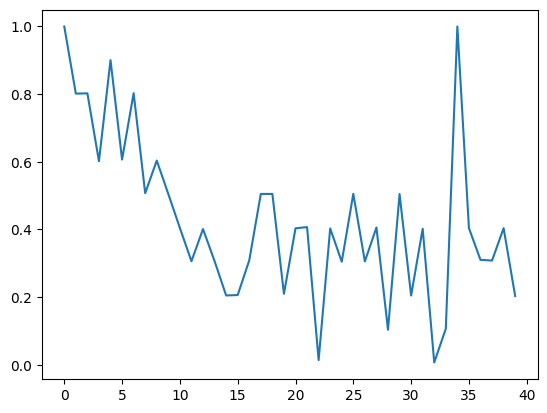

In [27]:
plt.plot(y)

In [22]:
print(len(y))

34


In [ ]:
x_test = x[10000:]
Zs = []
for pattern in tqdm.tqdm(patterns):
    Zs.append(sample_z_vectors(x[:10000], pattern))

100%|██████████| 10000/10000 [04:51<00:00, 34.29it/s]


In [ ]:
predictions = []
x_train = x[:10000]
for h in range(50):
    S = []
    for i, pattern in tqdm.tqdm(enumerate(patterns)):
        z_new = sample_z_new(x_train, pattern)
        S.extend(Zs[i][np.linalg.norm(Zs[i][:, :-1] - z_new, axis=1) < 0.01][:, -1])
    y_hat = dbscan(S)
    x_train = np.append(x_train, y_hat)
    predictions.append(y_hat)

10000it [00:06, 1480.83it/s]
10000it [00:06, 1621.45it/s]
10000it [00:06, 1660.48it/s]
10000it [00:06, 1505.01it/s]
10000it [00:05, 1675.38it/s]
10000it [00:07, 1359.16it/s]
10000it [00:05, 1677.50it/s]
10000it [00:06, 1560.88it/s]
10000it [00:06, 1666.14it/s]
10000it [00:06, 1564.38it/s]
10000it [00:05, 1696.01it/s]
10000it [00:06, 1546.93it/s]
10000it [00:06, 1623.98it/s]
10000it [00:05, 1680.06it/s]
10000it [00:06, 1600.39it/s]
10000it [00:06, 1656.88it/s]
10000it [00:06, 1656.37it/s]
10000it [00:06, 1580.36it/s]
10000it [00:05, 1713.19it/s]
10000it [00:06, 1551.45it/s]
10000it [00:05, 1741.70it/s]
10000it [00:06, 1530.90it/s]
10000it [00:05, 1740.85it/s]
10000it [00:06, 1548.56it/s]
10000it [00:05, 1712.54it/s]
10000it [00:06, 1517.22it/s]
10000it [00:05, 1715.81it/s]
10000it [00:06, 1595.10it/s]
10000it [00:06, 1628.62it/s]
10000it [00:05, 1676.82it/s]
10000it [00:06, 1577.31it/s]
10000it [00:05, 1712.00it/s]
10000it [00:06, 1516.82it/s]
10000it [00:05, 1714.00it/s]
10000it [00:06

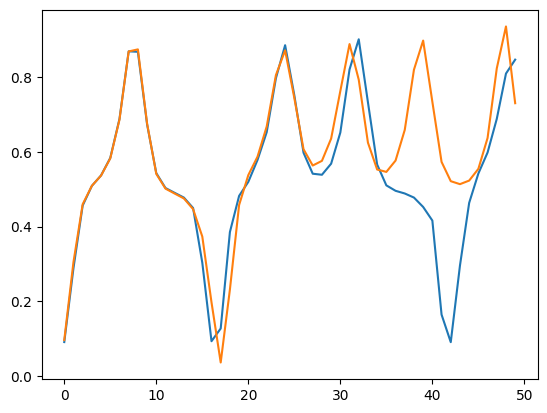

In [ ]:
plt.plot(predictions)
plt.plot(x_test[:50])

In [ ]:
x_new = x[:1100].copy()
for i in range(1000, 1100, 10):
    x_new[i] = 0
result = self_healing(Zs, x_new, patterns)

10000it [00:08, 1182.61it/s]
10000it [00:07, 1261.16it/s]
10000it [00:08, 1226.59it/s]
10000it [00:07, 1364.18it/s]
10000it [00:07, 1410.78it/s]
10000it [00:12, 817.19it/s]
10000it [00:08, 1170.39it/s]
10000it [00:07, 1376.40it/s]
10000it [00:07, 1331.86it/s]
10000it [00:04, 2344.24it/s]


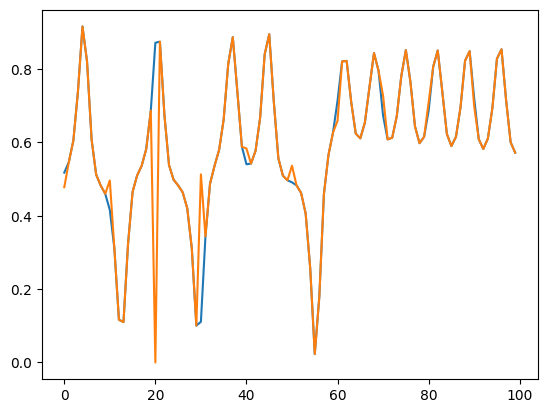

In [ ]:
plt.plot(x[1000:1100])
plt.plot(x_new[1000:1100])

In [ ]:
result = []
for i in range(31):
    x_new = x[:1100].copy()
    random_numbers = np.random.choice(np.arange(100), size = i, replace=False)
    for j in range(i):
        x_new[1000 + random_numbers[j]] = 0
    Zs = []
    for pattern in tqdm.tqdm(patterns):
        Zs.append(sample_z_vectors(x_new, pattern))
    result.append(self_healing(Zs, x_new, patterns))

100%|██████████| 10000/10000 [00:24<00:00, 408.71it/s]
10000it [00:03, 3271.51it/s]
100%|██████████| 10000/10000 [00:24<00:00, 408.61it/s]
10000it [00:01, 8135.97it/s]
10000it [00:00, 13350.08it/s]
100%|██████████| 10000/10000 [00:24<00:00, 414.24it/s]
10000it [00:03, 3313.92it/s]
10000it [00:01, 5071.48it/s]
10000it [00:00, 18697.84it/s]
100%|██████████| 10000/10000 [00:23<00:00, 423.93it/s]
10000it [00:03, 3088.31it/s]
10000it [00:02, 4713.77it/s]
10000it [00:02, 4544.33it/s]
10000it [00:02, 4175.10it/s]
100%|██████████| 10000/10000 [00:24<00:00, 402.61it/s]
10000it [00:02, 4125.92it/s]
10000it [00:02, 4423.39it/s]
10000it [00:03, 3217.74it/s]
10000it [00:02, 3600.74it/s]
10000it [00:00, 15315.31it/s]
100%|██████████| 10000/10000 [00:24<00:00, 400.42it/s]
10000it [00:02, 4131.43it/s]
10000it [00:02, 4613.59it/s]
10000it [00:02, 4676.86it/s]
10000it [00:02, 4446.01it/s]
10000it [00:02, 4630.15it/s]
10000it [00:01, 5709.18it/s]
100%|██████████| 10000/10000 [00:23<00:00, 425.64it/s]
100

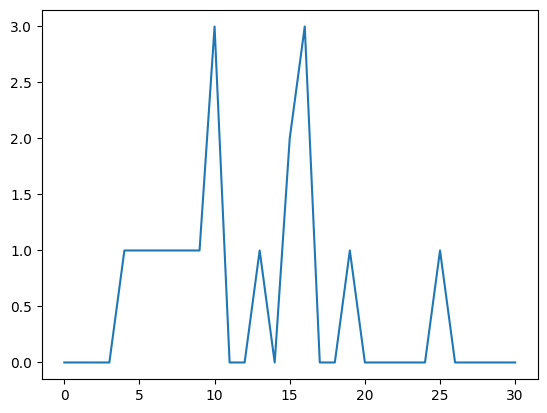

In [ ]:
plt.plot(result)

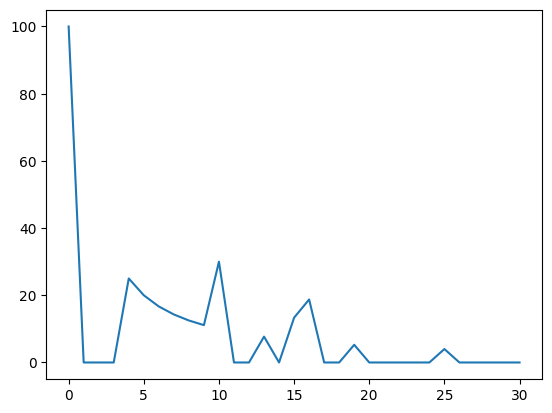

In [ ]:
procent_result = [100]
for i in range(1, len(result)):
    procent_result.append((100 * result[i]) / i)
plt.plot(procent_result)